# Bài tập về nhà 02: Phân loại chữ số viết tay (MNIST)

## 1. Chuẩn bị Data

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Kiểm tra xem có GPU không, nếu có thì dùng cho nhanh
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Các tham số hằng số (Hyperparameters)
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 5

Using device: cpu


In [10]:
# Tải dữ liệu MNIST
# `transform` giúp chuyển ảnh sang Tensor và chuẩn hóa về khoảng [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Số lượng ảnh train: {len(train_dataset)}")
print(f"Số lượng ảnh test: {len(test_dataset)}")

Số lượng ảnh train: 60000
Số lượng ảnh test: 10000


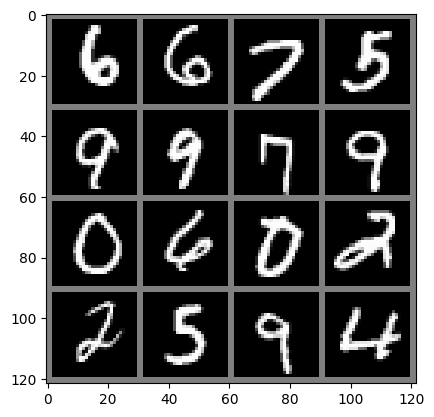

Labels: [6, 6, 7, 5, 9, 9, 7, 9, 0, 6, 0, 2, 2, 5, 9, 4]


In [11]:
# Hiển thị thử một vài ảnh để xem mặt mũi dữ liệu thế nào
def imshow(img):
    img = img / 2 + 0.5  # unnormalize (đưa về lại khoảng [0, 1] để hiển thị)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Lấy một batch ngẫu nhiên
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Hiển thị 16 ảnh đầu tiên trong batch
imshow(torchvision.utils.make_grid(images[:16], nrow=4))
print('Labels:', labels[:16].tolist())

## 2. Xây dựng mô hình

In [12]:
class ANN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
        super(ANN, self).__init__()
        self.flatten = nn.Flatten()               # Duỗi ảnh 2D thành 1D
        self.fc1 = nn.Linear(input_size, hidden_size)  # Lớp ẩn
        self.relu = nn.ReLU()                     # Hàm kích hoạt phi tuyến
        self.fc2 = nn.Linear(hidden_size, num_classes) # Lớp đầu ra
        # Lưu ý: CrossEntropyLoss của PyTorch đã bao gồm Softmax, nên không cần thêm Softmax vào cuối model

    def forward(self, x):
        out = self.flatten(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = ANN().to(device)
print(model)

ANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 3. Training

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_history = []

print("Bắt đầu luyện công...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # 1. Forward pass: Chạy dữ liệu qua mô hình
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 2. Backward and optimize: Tính đạo hàm và cập nhật trọng số
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Tính loss trung bình cho epoch này
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}')

print("Training Finished")

Bắt đầu luyện công...
Epoch [1/5], Loss: 0.3749
Epoch [2/5], Loss: 0.1864
Epoch [3/5], Loss: 0.1353
Epoch [4/5], Loss: 0.1107
Epoch [5/5], Loss: 0.0938
Training Finished


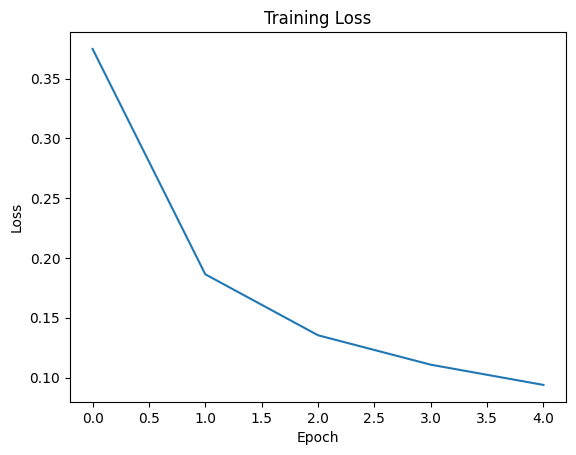

In [14]:
# Vẽ đồ thị Loss để xem quá trình học
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 4. Test

In [15]:
correct = 0
total = 0
# Không cần tính gradient khi test để tiết kiệm bộ nhớ
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Độ chính xác trên 10,000 ảnh test: {100 * correct / total} %')

Độ chính xác trên 10,000 ảnh test: 97.08 %


Thực tế:  [7, 2, 1, 0, 4]
Dự đoán:  [7, 2, 1, 0, 4]


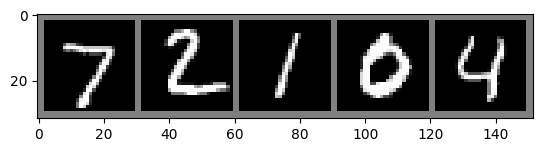

In [16]:
# Thử dự đoán một vài ảnh cụ thể
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

output = model(images[:5])
_, predicted = torch.max(output, 1)

print('Thực tế: ', labels[:5].cpu().tolist())
print('Dự đoán: ', predicted.cpu().tolist())

imshow(torchvision.utils.make_grid(images[:5].cpu(), nrow=5))